In [1]:
import numpy as np
import xarray as xr
import healpy as hp

import intake
from easygems import healpix as egh

import matplotlib.pyplot as plt
import cmocean as cm

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature

import pandas as pd
import geopandas as gpd
import osmnx as ox
import rioxarray
from rasterio import features

from shapely.geometry import Point, Polygon, MultiPolygon

from easygems.healpix import attach_coords

In [2]:
zoom = 10
# file = '/scratch/nf33/Healpix_data/UM/data.healpix.PT3H.z' + zoom + '.zarr'

direc = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT3H.z" + str(zoom) +".zarr" # UM PT1H is hourly data
# direc = "/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z11_atm.zarr" #PT1H is hourly data
ds = xr.open_zarr(direc)
ds = ds.pipe(egh.attach_coords)
ds

<xarray.Dataset> Size: 53TB
Dimensions:   (time: 3497, pressure: 25, cell: 12582912)
Coordinates:
  * pressure  (pressure) int64 200B 1 5 10 20 30 50 ... 875 900 925 950 975 1000
  * time      (time) datetime64[ns] 28kB 2020-01-20 ... 2021-04-01
    crs       int64 8B 0
  * cell      (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
    lat       (cell) float64 101MB 0.0373 0.0746 0.0746 ... -0.0746 -0.0373
    lon       (cell) float64 101MB 45.0 45.04 44.96 45.0 ... 315.0 315.0 315.0
Data variables:
    cli       (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
    clw       (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
    hur       (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
    hus       (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
    qg        (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
    qr        (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
    qs        (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
    ta        (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
    ua        (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
    va        (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
    wa        (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
    zg        (time, pressure, cell) float32 4TB dask.array<chunksize=(1, 1, 1048576), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n2560_RAL3p3
    simulation_description:           The MetUM uses a regular lat-lon grid, ...

In [4]:
%%time
## Masking for land exclude ocean

sftlf = xr.open_zarr("/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z" + str(zoom) +".zarr").sftlf.load()

ds_ts = ds.ta.where(sftlf>0)
ds_wa = ds.wa.where(sftlf>0)

CPU times: user 475 ms, sys: 531 ms, total: 1.01 s
Wall time: 2.6 s


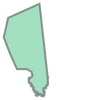

In [5]:
## Cities

cities = [
    "Jakarta"
]
gdf = ox.geocode_to_gdf(cities)

gdf.geometry.iloc[0]

In [6]:
geo_centroid = [gdf.geometry.centroid.x.iloc[0], gdf.geometry.centroid.y.iloc[0]]

boundary_coords = np.array(gdf.geometry.iloc[0].exterior.coords)

/jobfs/141072901.gadi-pbs/ipykernel_1008483/648222507.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_centroid = [gdf.geometry.centroid.x.iloc[0], gdf.geometry.centroid.y.iloc[0]]


In [7]:
ds_ts_clip = ds_ts.where((ds.lon > boundary_coords[:, 0].min()-0.5) & (ds.lon < boundary_coords[:, 0].max()+0.5) \
                       & (ds.lat > boundary_coords[:, 1].min()-0.5) & (ds.lat < boundary_coords[:, 1].max()+0.5), drop=True )

In [8]:
ds_wa_clip = ds_wa.where((ds.lon > boundary_coords[:, 0].min()-0.5) & (ds.lon < boundary_coords[:, 0].max()+0.5) \
                       & (ds.lat > boundary_coords[:, 1].min()-0.5) & (ds.lat < boundary_coords[:, 1].max()+0.5), drop=True )

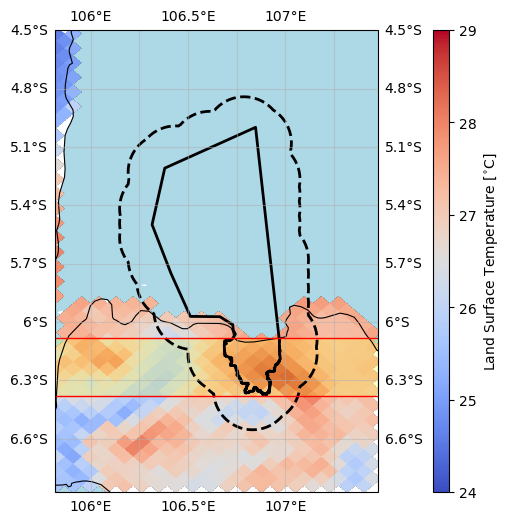

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([boundary_coords[:, 0].min()-0.5, boundary_coords[:, 0].max()+0.5,
               boundary_coords[:, 1].min()-0.5, boundary_coords[:, 1].max()+0.5], crs=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)
ax.add_feature(cf.OCEAN, facecolor='lightblue')
# ax.set(xlabel='longitude', ylabel='latitude')

gridlines = ax.gridlines(draw_labels=True, alpha=0.5)

artist = egh.healpix_show((ds_ts_clip-273.15).isel(time=21, pressure=-1), cmap='coolwarm', vmin=24, vmax=29)
# artist = egh.healpix_show((ds_um_.ts - ds_icon_.ts), cmap='coolwarm', vmin=-5, vmax=5)
fig.colorbar(artist, label=r"Land Surface Temperature [$^{\circ}$C]", orientation="vertical", pad=0.12, aspect=30)
# fig.colorbar(artist, label=r"$\Delta$ T [$^{\circ}$C]", orientation="vertical", pad=0.05)

city_boundary = ShapelyFeature(gdf["geometry"][0], ccrs.PlateCarree(), edgecolor='k',
                               facecolor='none', linestyle='-', linewidth=2)

city_buffer   = ShapelyFeature(buffered_city, ccrs.PlateCarree(), edgecolor='k',
                               facecolor='none', linestyle='--', linewidth=2)
ax.add_feature(city_boundary)
ax.add_feature(city_buffer)

y_coords = [-6.08, -6.38]
for y in y_coords:
    ax.hlines(y, 105, 108, color='red', linewidth=1, transform=ccrs.PlateCarree())
ax.fill_between(x=np.arange(105, 110), y1=-6.08, y2=-6.38, color='yellow',  interpolate=True, alpha=.2)
# ax.plot(geo_centroid[0], geo_centroid[1], marker='o', c='k')
# ax.plot(x, y, '--', c='k')

plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/jkt_slice.png', bbox_inches='tight', dpi=200, )
# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/ts_mean_um_jkt.png', bbox_inches='tight', dpi=200, )
# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/ts_mean_icon_jkt.png', bbox_inches='tight', dpi=200, )
# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/ts_mean_diff_um_icon_jkt.png', bbox_inches='tight', dpi=200, )

In [9]:
### masking city data with buffer

lat = ds_ts_clip.lat
lon = ds_ts_clip.lon

cell_points = gpd.GeoSeries([Point(lon[i].item(), lat[i].item()) for i in range(len(lat))], crs="EPSG:4326")

city_polygon = gdf.geometry.iloc[0]
cell_in_city = cell_points.within(city_polygon)
land_points = gpd.GeoDataFrame(geometry=cell_points[cell_in_city], crs="EPSG:4326")

if not land_points.empty:
    land_union = land_points.unary_union
    buffered_city = land_union.buffer(0.2)  # buffer by ~0.2 degrees (~20 km)
    buffered_city_mask = cell_points.within(buffered_city)

cell_mask_city = xr.DataArray(cell_in_city.values, dims=["cell"])
cell_mask_buffer = xr.DataArray(buffered_city_mask.values, dims=["cell"])

ts_region = ds_ts_clip.where(cell_mask_buffer)

ts_city = ts_region.where(cell_mask_city)  # masking city
ts_outside = ts_region.where(~cell_mask_city)  # masking outside city

/jobfs/141072901.gadi-pbs/ipykernel_1008483/2303640682.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  land_union = land_points.unary_union


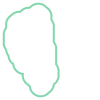

In [9]:
buffered_city.exterior

## Maridional average vertical slices

In [97]:
Slim, Nlim = -6.38, -6.08
t1, t2 = '2020-01-23T00', '2020-02-05T00'
ta_by_lon = (
    ds_ts_clip
    # .sel(time=slice(t1, t2))
    .isel(time=slice(0, 110))
    .where((ds["lat"] > Slim) & (ds["lat"] < Nlim), drop=True)
    .groupby("lon")
    .mean()
).compute()

In [98]:
ta_rural_by_lon = (
    ts_outside
    # .sel(time=slice(t1, t2))
    .isel(time=slice(0, 110))
    # .where((ds["lat"] > Slim) & (ds["lat"] < Nlim), drop=True)
    .groupby("lon")
    .mean()
).compute()

In [99]:
wa_by_lon = (
    ds_wa_clip
    # .sel(time=slice(t1, t2))
    .isel(time=slice(0, 110))
    .where((ds["lat"] > Slim) & (ds["lat"] < Nlim), drop=True)
    .groupby("lon")
    .mean()
).compute()

In [100]:
ta_prime_by_lon = ta_by_lon - ta_rural_by_lon.mean('lon') #.isel(pressure=-1) #.fillna(273.15)

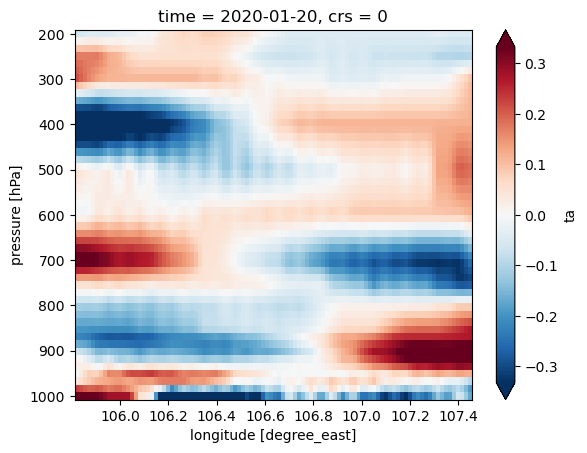

In [101]:
ta_prime_by_lon.isel(time=0).interp(pressure=np.linspace(1000,200,50)) \
    .interp(lon=np.linspace(ta_by_lon.lon.min().values,ta_by_lon.lon.max().values,100)).plot(robust=True, x='lon', yincrease=False)


In [66]:
D1 = wa_by_lon.interp(pressure=np.linspace(1000,500,100)) \
        .interp(lon=np.linspace(wa_by_lon.lon.min().values,wa_by_lon.lon.max().values,100))

D2 = ta_prime_by_lon.interp(pressure=np.linspace(1000,500,100)) \
        .interp(lon=np.linspace(ta_prime_by_lon.lon.min().values,ta_prime_by_lon.lon.max().values,100))

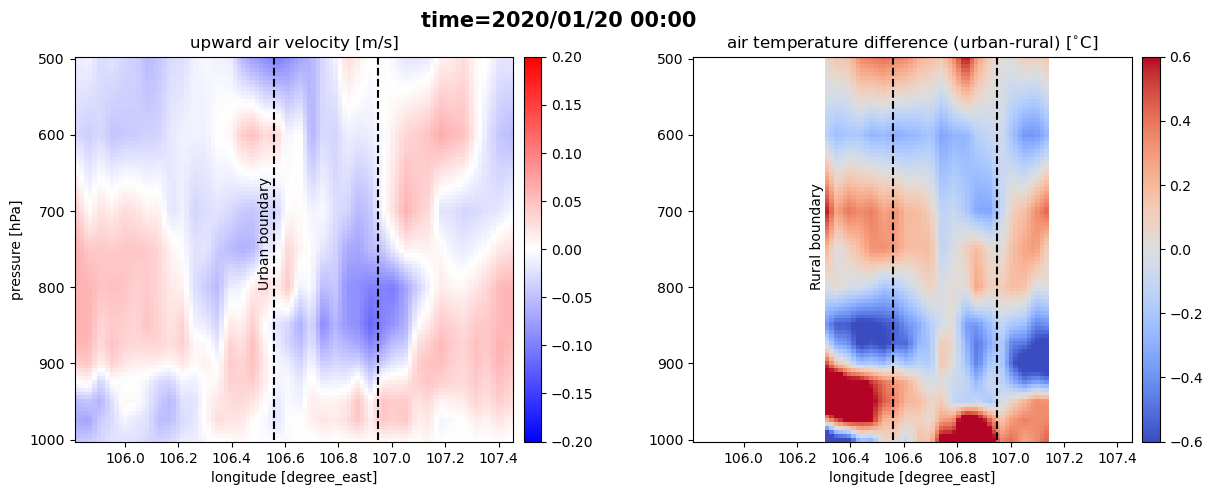

In [57]:
fig, ax = plt.subplots(1,5, figsize=(14,5), width_ratios=[1,0.04, 0.3, 1,0.04])

c1 = D1.isel(time=itm).plot(x="lon", yincrease=False, ax=ax[0], add_colorbar = False, vmin=-0.2, vmax=0.2, cmap='bwr')
cbar1 = fig.colorbar(c1, cax=ax[1],  shrink = 1)

c2 = D2.isel(time=itm).plot(x="lon", yincrease=False, ax=ax[3], add_colorbar = False, vmin=-0.6, vmax=0.6, cmap='coolwarm')
cbar2 = fig.colorbar(c2, cax=ax[4],  shrink = 1)

ax[2].axis("off")
ax[0].plot([106.56, 106.56], [1000, 1], c='k', ls='--')
ax[0].plot([106.95, 106.95], [1000, 1], c='k', ls='--')

ax[3].plot([106.56, 106.56], [1000, 1], c='k', ls='--')
ax[3].plot([106.95, 106.95], [1000, 1], c='k', ls='--')

ax[0].set(title='upward air velocity [m/s]')
ax[3].set(title=r'air temperature difference (urban-rural) [$^{\circ}$C]', ylabel='')

ax[1].set(ylabel='')
ax[4].set(ylabel='')

ax[3].text(106.25, 800, 'Rural boundary', rotation=90)
ax[0].text(106.5, 800, 'Urban boundary', rotation=90)
ax[2].text(-0.99, 1.08, 'time=' + str(D1.time[0].dt.strftime("%G/%m/%d %H:%M").data), weight='bold', size=15)

plt.subplots_adjust(wspace=0.05, hspace=0)

## Animations

In [31]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from matplotlib import animation

In [102]:
D1 = wa_by_lon.interp(pressure=np.linspace(1000,500,100)) \
        .interp(lon=np.linspace(wa_by_lon.lon.min().values,wa_by_lon.lon.max().values,100))

D2 = ta_prime_by_lon.interp(pressure=np.linspace(1000,500,100)) \
        .interp(lon=np.linspace(ta_prime_by_lon.lon.min().values,ta_prime_by_lon.lon.max().values,100))

In [103]:
### Offsetting time acording to Jakarta

offset = pd.tseries.frequencies.to_offset("7h")

D1["time"] = offset + D1.get_index("time")
D2["time"] = offset + D2.get_index("time")

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(14,5), width_ratios=[1,0.04, 0.3, 1,0.04])

c1 = D1.isel(time=0).plot(x="lon", yincrease=False, ax=ax[0], add_colorbar = False, vmin=-0.2, vmax=0.2, cmap='bwr')
cbar1 = fig.colorbar(c1, cax=ax[1],  shrink = 1)

c2 = D2.isel(time=0).plot(x="lon", yincrease=False, ax=ax[3], add_colorbar = False, vmin=-0.6, vmax=0.6, cmap='coolwarm')
cbar2 = fig.colorbar(c2, cax=ax[4],  shrink = 1)

ax[2].axis("off")
ax[0].plot([106.56, 106.56], [1000, 1], c='k', ls='-')
ax[0].plot([106.95, 106.95], [1000, 1], c='k', ls='-')
ax[3].plot([106.56, 106.56], [1000, 1], c='k', ls='-')
ax[3].plot([106.95, 106.95], [1000, 1], c='k', ls='-')

ax[0].plot([106.31, 106.3],[1000, 500], c='k', ls='--')
ax[0].plot([107.15, 107.15],[1000, 500], c='k', ls='--')
ax[3].plot([106.31, 106.3],[1000, 500], c='k', ls='--')
ax[3].plot([107.15, 107.15],[1000, 500], c='k', ls='--')

ax[0].set(title='upward air velocity [m/s]')
ax[3].set(title=r'air temperature difference (urban-rural) [$^{\circ}$C]', ylabel='')

ax[1].set(ylabel='')
ax[4].set(ylabel='')



ax[0].text(106.25, 800, 'Rural boundary', rotation=90)
ax[0].text(106.5, 800, 'Urban boundary', rotation=90)
tx1 = ax[2].text(-1.2, 1.08, 'time=' + str(D1.time[0].dt.strftime("%G/%m/%d %H:%M").data) + ' in Jakarta, Indonesia ', weight='bold', size=15)

# tx1 = ax[0].set_title('Frame 0')

plt.tight_layout()

# Function to update the contour plot for each frame
def update(frame):
    
    c1 = D1.isel(time=frame).plot(x="lon", yincrease=False, ax=ax[0], vmin=-0.2, vmax=0.2, add_colorbar=False, cmap='bwr')
    c2 = D2.isel(time=frame).plot(x="lon", yincrease=False, ax=ax[3], vmin=-0.6, vmax=0.6, add_colorbar=False, cmap='coolwarm')
    
    tx1.set_text('time=' + str(D1.time[frame].dt.strftime("%G/%m/%d %H:%M").data) + ' in Jakarta, Indonesia')

    ax[0].set(title='upward air velocity [m/s]')
    ax[3].set(title=r'air temperature difference (T-T$_{rural, avg}$) [$^{\circ}$C]', ylabel='')
    
    return c1, c2,


plt.subplots_adjust(wspace=0.05, hspace=0)
# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=100, interval=500)

# Save the animation to a file
ani.save("/g/data/hh5/tmp/ab2462/heckathon2025/animation_v4.mp4", writer='ffmpeg', fps=3, dpi=200,  savefig_kwargs={'bbox_inches': 'tight'})
# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/LST_jkt.png', bbox_inches='tight', dpi=200, )

# Show the animation
plt.show()

/jobfs/141072901.gadi-pbs/ipykernel_1008483/2649921273.py:34: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()
